In [12]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle


import sys, os
# sys.path.append(os.path.abspath('..'))
from lib.utils import load_candles


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 0.5 

mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 0.5, 'figure.dpi': 300})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

# optional 'chdir' (if not installed via 'pip' -> ModuleNotFoundError)
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import os
# module_path = './gym_pk'
# if not os.path.exists(module_path):
#     os.chdir('../')
# ------------------------------------------------------------

import gymnasium as gym
import gym_pk
from gym_pk.agents import QAgent

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = load_candles(exchange=exchange, pair=pair, timeframe=timeframe)

odf['cdir'] = -1 + 2 *(odf.close > odf.open)
odf['grflip'] = (odf.cdir != odf.cdir.shift()).fillna(0).cumsum()
odf['cudir'] = odf[['cdir', 'grflip']].groupby('grflip')[['cdir']].cumsum().clip(-5,5)

odf['lret'] = odf.close.divide(odf.open).apply(np.log)

horizon = 4
future_prices = pd.DataFrame(dict(min_low_ret=odf.low.rolling(horizon).min().shift(-horizon).divide(odf.close).apply(np.log),
max_high_ret=odf.high.rolling(horizon).max().shift(-horizon).divide(odf.close).apply(np.log),
close_ret=odf.close.shift(-horizon).divide(odf.close).apply(np.log))
)
# odf['ncudir'] = odf.cudir.add(5).subtract(odf.cudir > 0)
# odf = odf['2020-01-01':]
future_prices

,min_low_ret,max_high_ret,close_ret
dtime,,,
2017-08-17 04:00:00,-0.034913,0.030652,-0.015034
2017-08-17 08:00:00,-0.068397,0.013036,-0.030946
2017-08-17 12:00:00,-0.051321,0.003978,-0.012040
2017-08-17 16:00:00,-0.045072,0.010645,0.003480
2017-08-17 20:00:00,-0.035746,0.019972,-0.011310
...,...,...,...
2023-06-01 16:00:00,-0.013405,0.012957,0.009930
2023-06-01 20:00:00,NaN,NaN,NaN
2023-06-02 00:00:00,NaN,NaN,NaN


In [109]:
features = ['cudir']

cat_features = odf[features].astype('category')
cat_feature_codes = cat_features.apply(lambda x: x.cat.codes)
cat_feature_counts = cat_features.dtypes.apply(lambda x: x.categories.shape[0])
cat_feature_counts


cudir    10
dtype: int64

In [110]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

state_features_specs = [('cudir', 1), ('cudir', 3), ('cudir', 5)]

# lagged_feature_codes = pd.concat({
#     k:v
#     for i, (feature, lag) in enumerate(lagged_features_specs)
#     for k in [f'{i}__{feature}_LAG_{lag}']
#     for v in [cat_feature_codes[feature].shift(lag)]
# }, axis=1).dropna().astype(int)#.values

# lagged_feature_codes.agg(lambda x:  print(x.values), axis=1)

signal_features = pd.concat({
    k:v
    for i, (feature, lag) in enumerate(state_features_specs)
    for k in [f'{feature}_LAG_{lag}']
    for v in [cat_features[feature].shift(lag)]
}, axis=1).dropna().astype(int)#.values


# state_features['feat_cat'] = state_features.agg(lambda x:  np.array2string(x.values, separator=',', formatter={'int_kind': lambda x: "{:>+}".format(x)}), axis=1)

# le.fit(state_features['feat_cat'])
if 'state_no' in odf.columns:
    odf.drop('state_no', axis=1, inplace=True)

# state_features['state_no'] = le.transform(state_features['feat_cat'].values).astype(int)
# state_features
# state_features[['state_no']]
# odf = odf.join(state_features[['state_no']]).dropna()
odf = odf.loc[signal_features.index]
# odf
signal_features

,cudir_LAG_1,cudir_LAG_3,cudir_LAG_5
dtime,,,
2017-08-18 00:00:00,-3,-1,1
2017-08-18 04:00:00,1,-2,2
2017-08-18 08:00:00,2,-3,-1
2017-08-18 12:00:00,3,1,-2
2017-08-18 16:00:00,-1,2,-3
...,...,...,...
2023-06-01 16:00:00,3,1,2
2023-06-01 20:00:00,-1,2,-1
2023-06-02 00:00:00,-2,3,1


In [111]:
# df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
df = odf 

window_size = 10
start_index = window_size
end_index = start_index + len(df)

env_name = "crypto-v0"

env = gym.make(
    env_name,
    max_episode_steps=300,
    prices = odf.close,
    signal_features = signal_features,
    future_prices = future_prices
)

print ('observation_space:', env.observation_space)

observation_space: Tuple(Discrete(10), Discrete(10), Discrete(10))


In [112]:
import random

#reproduce training and test
seed = 42
obs = env.reset(seed=seed)
random.seed(seed)

In [113]:
# hyperparameters
learning_rate = 0.01
n_episodes = 1_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = QAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    action_space=env.action_space
)

In [104]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 1000/1000 [00:29<00:00, 34.40it/s]


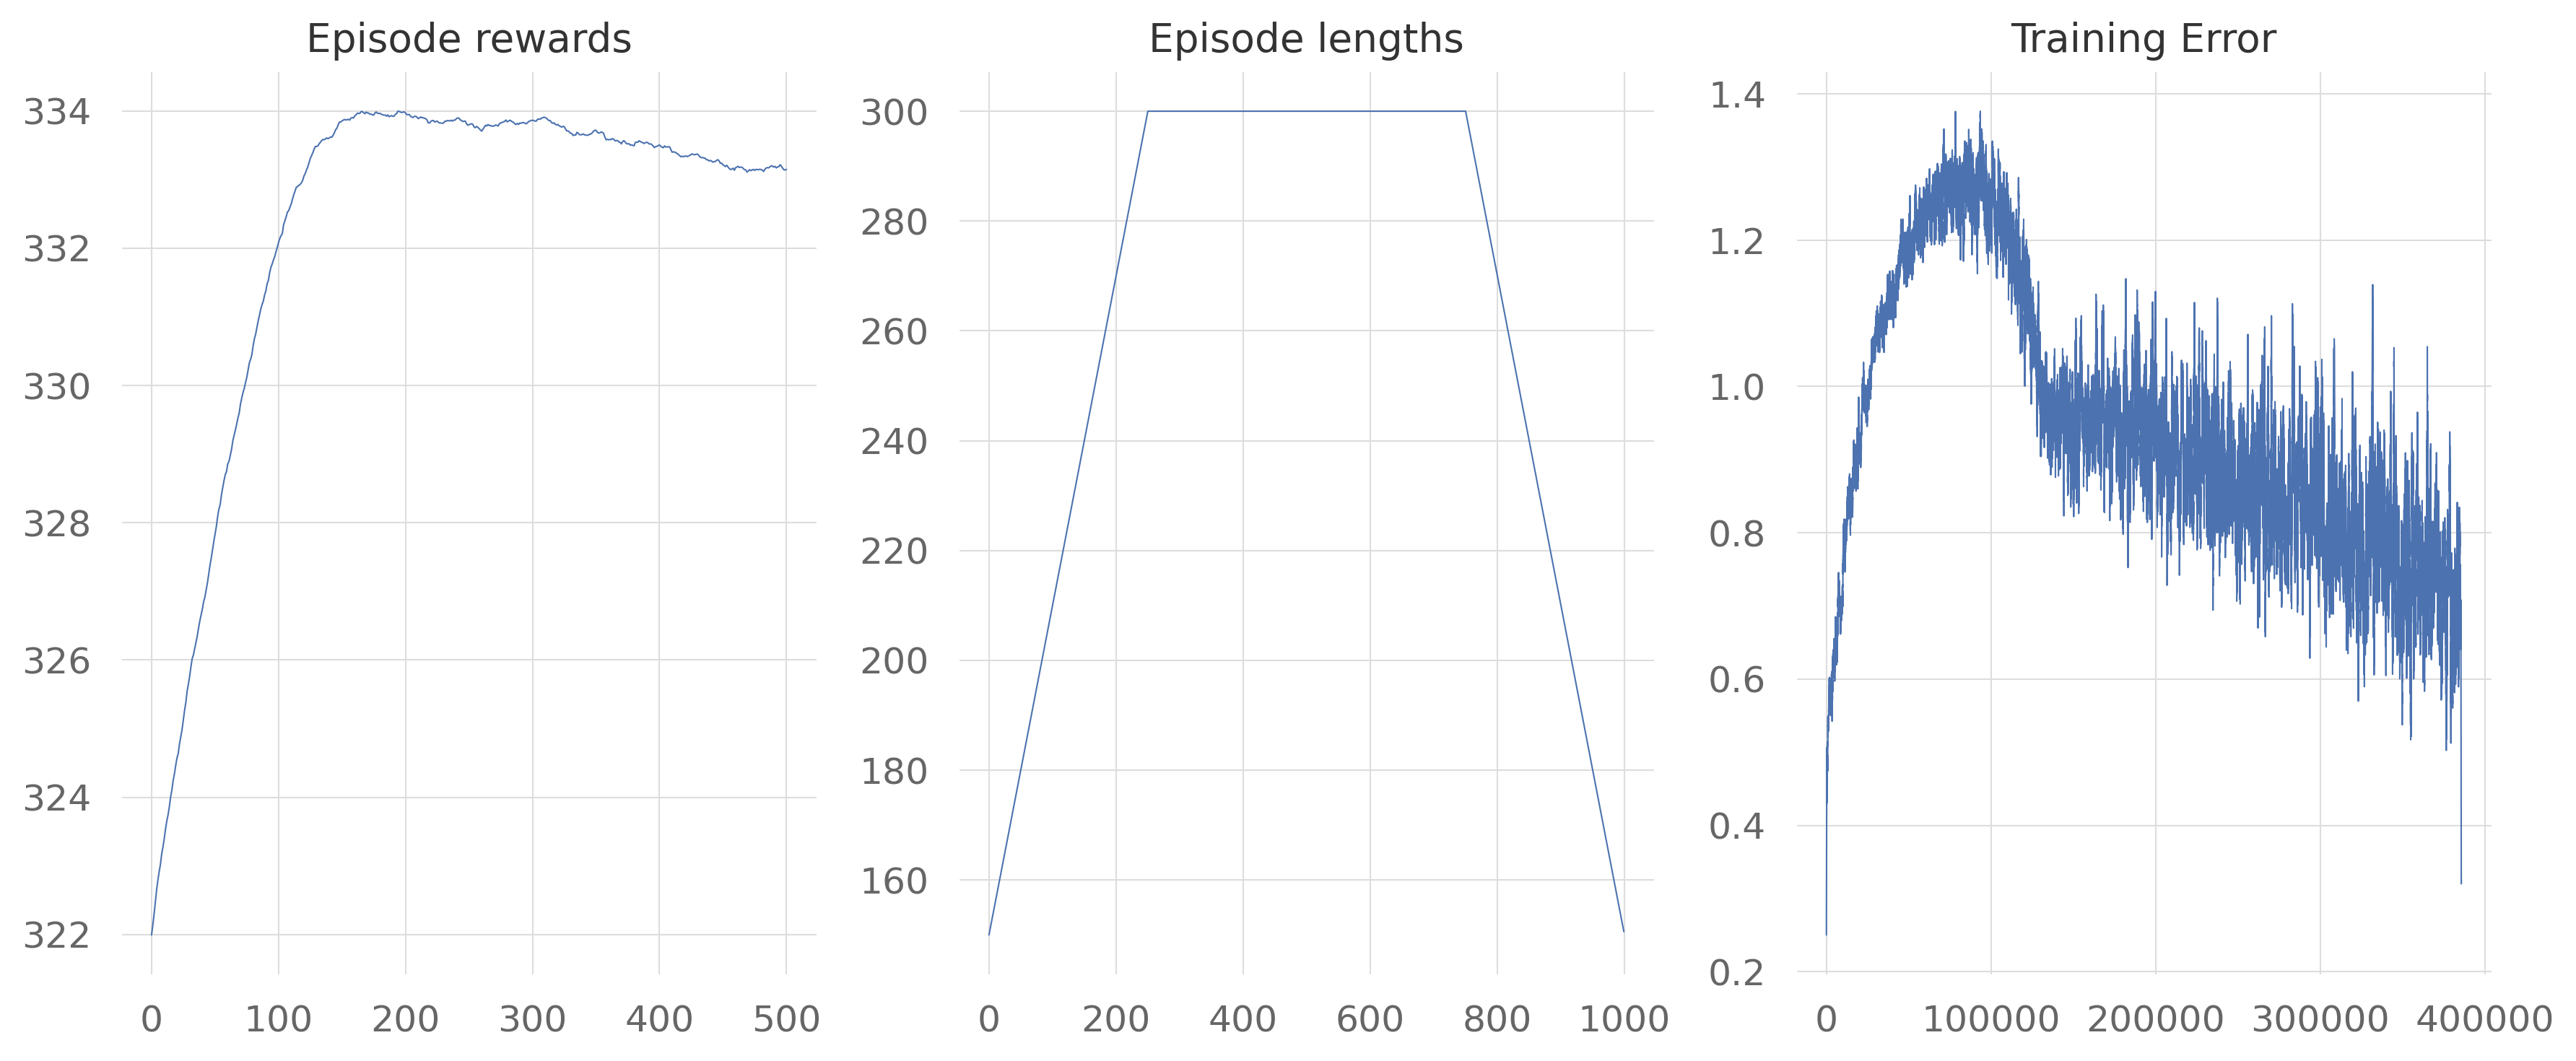

In [105]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [ ]:
agent.q_values

In [18]:
vec_env = model.get_env()
action_stats = {0:0, 1:0}
total_reward = 0

obs = vec_env.reset()

max_range = len(df) - 12 # max. range for env.render_all()

for i in range (max_range):

    action, _states = model.predict(obs)
    action_stats[action[0]] += 1

    obs, reward, done, info = vec_env.step(action)
    total_reward += reward

print("action_stats:", action_stats)
print("total_reward:", total_reward)

vec_env.close()

action_stats: {0: 7715, 1: 4949}
total_reward: [6.7194835e+08]


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.render_all to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_all` for environment variables or `env.get_attr('render_all')` that will search the reminding wrappers.
  logger.warn(


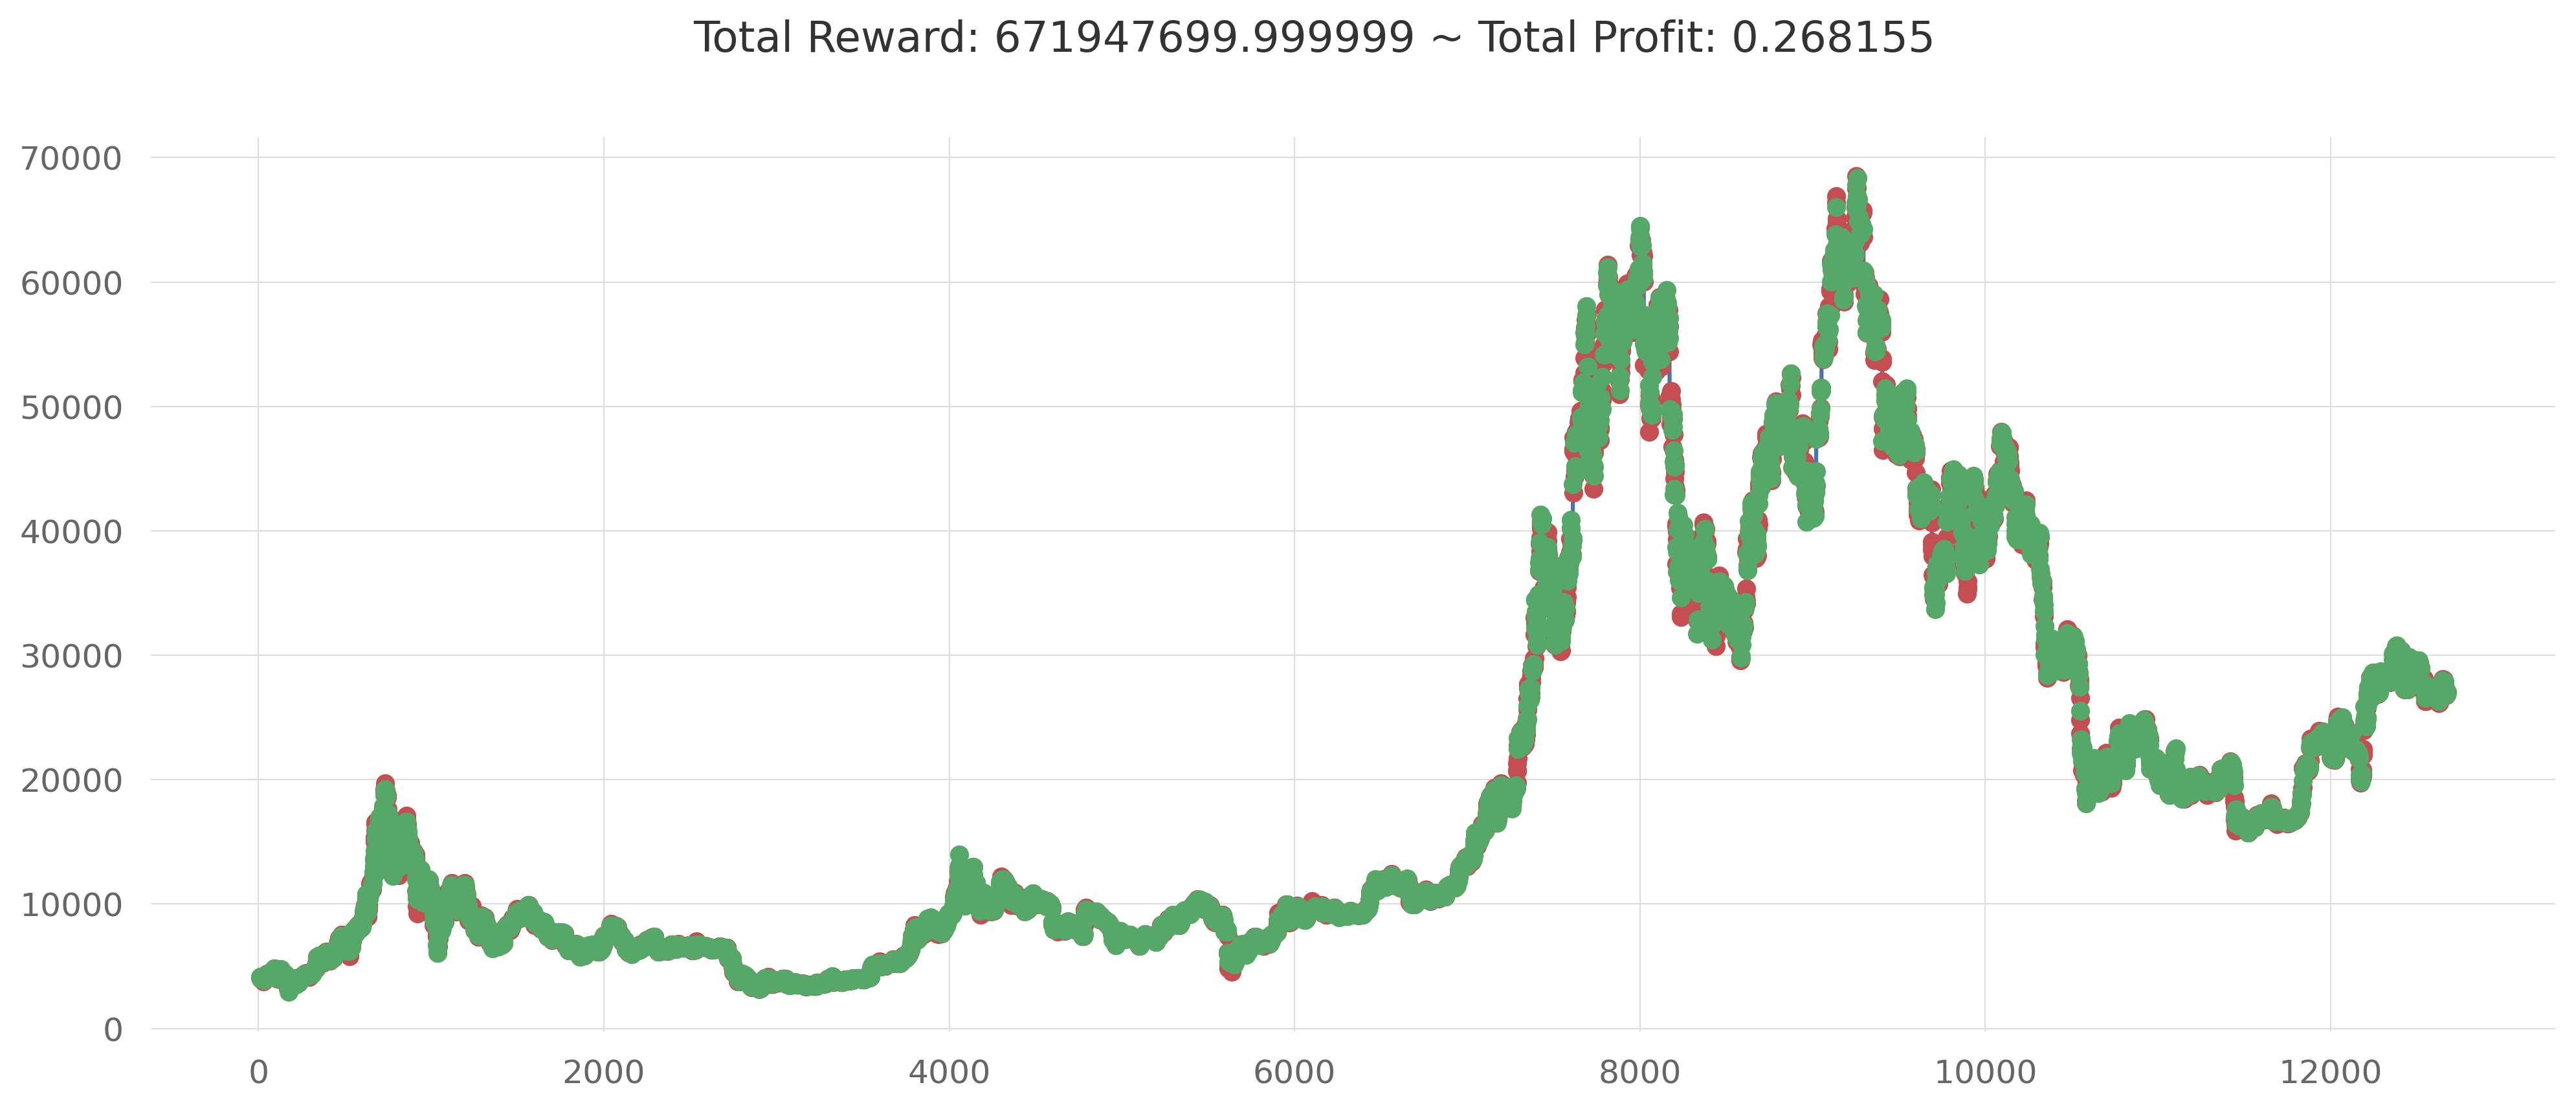

In [11]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()